In [1]:
import pandas as pd

In [2]:
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [3]:
from torch.utils.data import DataLoader

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

In [5]:
import os

In [48]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [49]:
from datasets import Dataset

In [6]:
MODEL = "prajjwal1/bert-mini"  # Optimized small model
tokenizer = BertTokenizerFast.from_pretrained(MODEL)

# Load Model
model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=2)  # Binary Classification

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
sentiment_dataset = load_dataset("imdb")  # Sentiment analysis dataset
suicide_dataset = load_dataset("vibhorag101/suicide_prediction_dataset_phr")  # Suicide detection dataset

In [9]:
print(suicide_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 185574
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 46394
    })
})


In [10]:
print(sentiment_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [11]:
# Function to convert string labels to numeric values
def map_labels(example):
    # SuicideWatch dataset: Convert "suicide" → 1, "non-suicide" → 0
    if example["label"] == "suicide":
        example["label"] = 1
    elif example["label"] == "non-suicide":
        example["label"] = 0

    return example

In [12]:
suicide_dataset = suicide_dataset.map(map_labels)

In [13]:
# Tokenize and Rename Labels Efficiently
def preprocess_function(batch):
    tokenized = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)
    tokenized["labels"] = [int(label) for label in batch["label"]]
    return tokenized

# Apply tokenization to both datasets
suicide_dataset = suicide_dataset.map(preprocess_function, batched=True)

In [14]:
sentiment_dataset = sentiment_dataset.map(preprocess_function, batched=True)

In [15]:
# Remove text column (no longer needed)
suicide_dataset = suicide_dataset.remove_columns(["text"])
sentiment_dataset = sentiment_dataset.remove_columns(["text"])

In [16]:
# Pytorch Dataset Wrapper
class MultiTaskDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(item["labels"], dtype=torch.long),
        }

# Wrap datasets
train_suicide_dataset = MultiTaskDataset(suicide_dataset["train"])
test_suicide_dataset = MultiTaskDataset(suicide_dataset["test"])

train_sentiment_dataset = MultiTaskDataset(sentiment_dataset["train"])
test_sentiment_dataset = MultiTaskDataset(sentiment_dataset["test"])

In [17]:
print(train_suicide_dataset)

In [18]:
# Create efficient dataloaders
BATCH_SIZE = 8  # Increase batch size for efficiency

train_suicide_loader = DataLoader(train_suicide_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_suicide_loader = DataLoader(test_suicide_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_sentiment_loader = DataLoader(train_sentiment_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_sentiment_loader = DataLoader(test_sentiment_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# Set Device (Supports Mac MPS and CUDA)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [20]:
print(f"Using device: {device}")

Using device: mps


In [21]:
# Define Optimizer & Loss Function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)  # Higher learning rate for BERT-Mini
loss_fn = nn.CrossEntropyLoss()  # Binary classification loss

In [22]:
# Model optimizations for less memory usage and better training

# Less dropout layers
for module in model.modules():
    if isinstance(module, torch.nn.Dropout):
        module.p = 0.05  # Reduce dropout

In [23]:
model.classifier = nn.Sequential(
    nn.LayerNorm(256),  # Normalize before classification
    nn.Linear(256, 2)   # Keep original classifier
)

In [30]:
model.half()  # Convert model weights to float16

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.05, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e

In [24]:
# Training Configurations
EPOCHS = 3 # More epochs compensate for smaller model

In [25]:
batch = next(iter(train_suicide_loader))
print(batch)

{'input_ids': tensor([[  101,  2028,  2154,  ...,     0,     0,     0],
        [  101,  2746,  4931,  ...,     0,     0,     0],
        [  101,  4931,  3424,  ...,     0,     0,     0],
        ...,
        [  101,  2562,  2893,  ...,     0,     0,     0],
        [  101,  3225,  2228,  ...,     0,     0,     0],
        [  101,  3100, 15958,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 0, 1, 0, 0, 1, 1, 0])}


In [26]:
print(type(model))

<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


In [27]:
# Ensure model is fully on the correct device
model.to(device)
for param in model.parameters():
    param.data = param.data.to(device)
    if param.grad is not None:
        param.grad.data = param.grad.data.to(device)

In [28]:
# Train model
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    total_loss = 0
    num_batches = min(len(train_suicide_loader), len(train_sentiment_loader))  # Ensure equal batches

    print(f"Epoch {epoch + 1}/{EPOCHS} - Training...")

    for batch_idx, (batch_suicide, batch_sentiment) in enumerate(zip(train_suicide_loader, train_sentiment_loader)):
        optimizer.zero_grad()

        # Suicide Task
        inputs = {key: val.to(device) for key, val in batch_suicide.items() if key in ["input_ids", "attention_mask"]}
        labels = batch_suicide["labels"].to(device)
        outputs = model(**inputs)
        loss_suicide = loss_fn(outputs.logits, labels)

        # Sentiment Task
        inputs = {key: val.to(device) for key, val in batch_sentiment.items() if key in ["input_ids", "attention_mask"]}
        labels = batch_sentiment["labels"].to(device)
        outputs = model(**inputs)
        loss_sentiment = loss_fn(outputs.logits, labels)

        # Combine Losses
        total_loss = (loss_suicide + loss_sentiment) / 2

        # Backpropagation
        total_loss.backward()  
        optimizer.step()

        # Logging Progress
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{num_batches} - Loss: {total_loss.item():.4f}")

    print(f"Epoch {epoch+1} completed. Avg Loss: {total_loss.item():.4f}")

print("Training complete!")

Epoch 1/3 - Training...
Batch 0/3125 - Loss: 1.0443
Batch 100/3125 - Loss: 0.4149
Batch 200/3125 - Loss: 0.2971
Batch 300/3125 - Loss: 0.3176
Batch 400/3125 - Loss: 0.2951
Batch 500/3125 - Loss: 0.1748
Batch 600/3125 - Loss: 0.3313
Batch 700/3125 - Loss: 0.3110
Batch 800/3125 - Loss: 0.4572
Batch 900/3125 - Loss: 0.3571
Batch 1000/3125 - Loss: 0.0798
Batch 1100/3125 - Loss: 0.2436
Batch 1200/3125 - Loss: 0.2445
Batch 1300/3125 - Loss: 0.1785
Batch 1400/3125 - Loss: 0.1334
Batch 1500/3125 - Loss: 0.3447
Batch 1600/3125 - Loss: 0.5881
Batch 1700/3125 - Loss: 0.2813
Batch 1800/3125 - Loss: 0.2918
Batch 1900/3125 - Loss: 0.3522
Batch 2000/3125 - Loss: 0.1048
Batch 2100/3125 - Loss: 0.0339
Batch 2200/3125 - Loss: 0.1975
Batch 2300/3125 - Loss: 0.3669
Batch 2400/3125 - Loss: 0.2788
Batch 2500/3125 - Loss: 0.0912
Batch 2600/3125 - Loss: 0.0892
Batch 2700/3125 - Loss: 0.0782
Batch 2800/3125 - Loss: 0.5040
Batch 2900/3125 - Loss: 0.0620
Batch 3000/3125 - Loss: 0.0405
Batch 3100/3125 - Loss: 0.2

In [29]:
# Save model
MODEL_PATH = "./trained_suicide_detection_model_mt"
# Ensure directory exists
os.makedirs(MODEL_PATH, exist_ok=True)

In [30]:
# Save model and tokenizer
model.save_pretrained(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

('./trained_suicide_detection_model_mt/tokenizer_config.json',
 './trained_suicide_detection_model_mt/special_tokens_map.json',
 './trained_suicide_detection_model_mt/vocab.txt',
 './trained_suicide_detection_model_mt/added_tokens.json',
 './trained_suicide_detection_model_mt/tokenizer.json')

In [100]:
# Test on suicide test data
import time
from sklearn.metrics import accuracy_score, classification_report

# Start timing
start_time = time.time()

# Set model to evaluation mode
model.eval()

true_labels = []
predictions = []

# Total number of batches in test dataset
num_batches = len(test_suicide_loader)

print(f"Evaluating on {num_batches} batches...\n")

with torch.no_grad():
    for batch_idx, batch in enumerate(test_suicide_loader):
        inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        # Get predicted class (0 = Non-Suicidal, 1 = Suicidal)
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == num_batches:
            print(f"Processed {batch_idx + 1}/{num_batches} batches...")

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
end_time = time.time()

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Total Time for Testing: {end_time - start_time:.2f} seconds")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Non-Suicidal", "Suicidal"]))

Evaluating on 5800 batches...

Processed 100/5800 batches...
Processed 200/5800 batches...
Processed 300/5800 batches...
Processed 400/5800 batches...
Processed 500/5800 batches...
Processed 600/5800 batches...
Processed 700/5800 batches...
Processed 800/5800 batches...
Processed 900/5800 batches...
Processed 1000/5800 batches...
Processed 1100/5800 batches...
Processed 1200/5800 batches...
Processed 1300/5800 batches...
Processed 1400/5800 batches...
Processed 1500/5800 batches...
Processed 1600/5800 batches...
Processed 1700/5800 batches...
Processed 1800/5800 batches...
Processed 1900/5800 batches...
Processed 2000/5800 batches...
Processed 2100/5800 batches...
Processed 2200/5800 batches...
Processed 2300/5800 batches...
Processed 2400/5800 batches...
Processed 2500/5800 batches...
Processed 2600/5800 batches...
Processed 2700/5800 batches...
Processed 2800/5800 batches...
Processed 2900/5800 batches...
Processed 3000/5800 batches...
Processed 3100/5800 batches...
Processed 3200/58

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

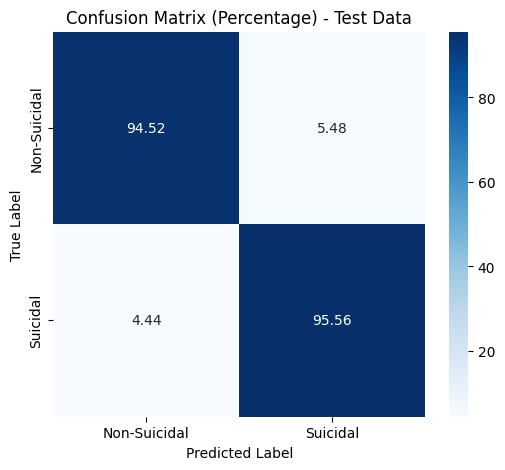

In [104]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Convert Confusion Matrix to Percentage
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix with Percentages
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Non-Suicidal", "Suicidal"], yticklabels=["Non-Suicidal", "Suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage) - Test Data")
plt.show()

In [32]:
# test on new user data
def predict_suicide_risk(text):
    model.eval()  # Set to evaluation mode

    # Tokenize input text
    inputs = tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    # Move inputs to the same device as the model
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get prediction label
    predicted_label = torch.argmax(probs, dim=-1).item()
    
    # Map label to class
    label_map = {0: "Non-Suicidal", 1: "Suicidal"}
    return label_map[predicted_label], probs.cpu().numpy()

# User Test
test_message = "I feel hopeless and don't want to live."
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.05502443 0.9449756 ]]


In [33]:
# User Test
test_message = "I'm doing ok!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.8835064  0.11649355]]


In [34]:
# User Test
test_message = "thank you for your help!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.29710996 0.70289004]]


In [35]:
# User Test
test_message = "hello!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.70705867 0.2929413 ]]


In [36]:
# User Test
test_message = "hi there"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.8006687  0.19933122]]


In [37]:
# User Test
test_message = "how are you?"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.80016035 0.19983967]]


In [38]:
# User Test
test_message = "I feel like dying"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.4488112 0.5511888]]


In [39]:
# User Test
test_message = "I want to hurt myself"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.14516436 0.8548356 ]]


In [40]:
# User Test
test_message = "Im fine. Just tired"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.67464495 0.32535508]]


In [41]:
# User Test
test_message = "I feel like dying right now. I hate everything"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.2283379 0.7716621]]


In [42]:
# User Test
test_message = "thanks!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.27888072 0.72111934]]


In [91]:
# User Test
test_message = "I want to die."
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.1814364  0.81856364]]


In [96]:
# User Test
test_message = "I feel hopeless and don't want to live."
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.05502443 0.9449756 ]]


In [84]:
# User Test
test_message = "What a nice evening"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.6047261  0.39527395]]


In [67]:
# Generalizability test

In [85]:
# Create Out-of-Distribution dataset (messages + labels)
ood_data = [
    {"text": "I feel good today!", "label": 0},  # Non-Suicidal
    {"text": "I feel like dying right now", "label": 1},  # Suicidal
    {"text": "What should I make for dinner?", "label": 0},  # Non-Suicidal
    {"text": "I hate everything about my life, I wish I could disappear", "label": 1},  # Suicidal
    {"text": "What a week! Life is crazy sometimes", "label": 0},  # Non-Suicidal
    {"text": "No one is going to miss if me if I was gone.", "label": 1},  # Suicidal
    {"text": "I'm so stressed with work, I need a break.", "label": 0},  # Non-Suicidal
    {"text": "I really want to hurt myself.", "label": 1},  # Suicidal
    {"text": "I wish I could fly!", "label": 0},  # Non-Suicidal
    {"text": "I want to jump off a cliff.", "label": 1},  # Suicidal
    {"text": "Sometimes I feel so happy, then I feel sad all of a sudden! I don't know why it happens!", "label": 0},  # Non-Suicidal
    {"text": "What if I kill myself?", "label": 1},  # Suicidal
    {"text": "I'm excited right now! I'm going to go kayaking soon.", "label": 0},  # Non-Suicidal
    {"text": "I feel really depressed. I think I should end it", "label": 1},  # Suicidal
    {"text": "I feel really depressed. Im working through it", "label": 0},  # Non-Suicidal
    {"text": "I wish I wasn't here.", "label": 1},  # Suicidal
    {"text": "So nervous! Everything feels like too much", "label": 0},  # Non-Suicidal
    {"text": "This is the end for me. I want to stop everything.", "label": 1},  # Suicidal
    {"text": "Whales are so cool right?", "label": 0},  # Non-Suicidal
    {"text": "My life is over.", "label": 1},  # Suicidal
    {"text": "Things are good!", "label": 0},  # Non-Suicidal
    {"text": "I don't want to be alive.", "label": 1},  # Suicidal
    {"text": "hello!", "label": 0},  # Non-Suicidal
    {"text": "life is over for me. like things feel so empty and I feel unsure about the future", "label": 1},  # Suicidal
    {"text": "I go hiking often. It's a fun activity", "label": 0},  # Non-Suicidal
    
    
    
]

In [86]:
def tokenize_function_ood(batch):
    """Tokenizes text and ensures labels are correctly formatted"""
    tokenized = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)
    tokenized["labels"] = [label for label in batch["label"]]  # Ensure labels are lists
    return tokenized

# Convert OOD data into Hugging Face Dataset format
ood_dataset = Dataset.from_list(ood_data)

# Apply tokenization
ood_dataset = ood_dataset.map(tokenize_function_ood, batched=True)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [87]:
# Convert tokenized OOD dataset into a PyTorch dataset
test_ood_dataset = MultiTaskDataset(ood_dataset)

In [88]:
# Convert to Dataloader
test_ood_loader = DataLoader(test_ood_dataset, batch_size=4, shuffle=False)

In [89]:
# Set model to evaluation mode
model.eval()

true_labels = []
predictions = []

# Evaluate on OOD dataset
with torch.no_grad():
    for batch_idx, batch in enumerate(test_ood_loader):
        inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

        print(f"Processed {batch_idx + 1}/{num_batches} batches...")

# Compute OOD Accuracy
ood_accuracy = accuracy_score(true_labels, predictions)
print(f"\nOOD Accuracy: {ood_accuracy:.4f}")

Processed 1/5800 batches...
Processed 2/5800 batches...
Processed 3/5800 batches...
Processed 4/5800 batches...
Processed 5/5800 batches...
Processed 6/5800 batches...
Processed 7/5800 batches...

OOD Accuracy: 0.7600


In [90]:
# Compute generalizability score
generalizability_score = ood_accuracy / accuracy

print(f"\n Generalizability Score: {generalizability_score:.4f}")


 Generalizability Score: 0.7997


In [94]:
# Define model save path
MODEL_PATH = "./saved_model"

# Save model & tokenizer
model.save_pretrained(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

print(f"✅ Model saved at {MODEL_PATH}")


✅ Model saved at ./saved_model


In [97]:
torch.save(model.state_dict(), f"{MODEL_PATH}/model_weights.pth")


OOD Accuracy: 0.7600

Classification Report:
              precision    recall  f1-score   support

Non-Suicidal       0.89      0.62      0.73        13
    Suicidal       0.69      0.92      0.79        12

    accuracy                           0.76        25
   macro avg       0.79      0.77      0.76        25
weighted avg       0.79      0.76      0.76        25



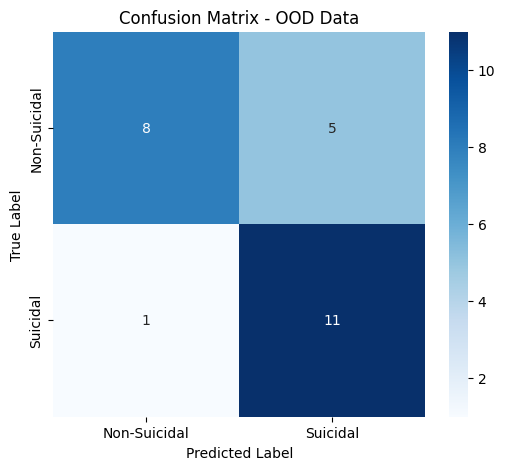

In [98]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set model to evaluation mode
model.eval()

true_labels = []
predictions = []

# Evaluate on OOD dataset
with torch.no_grad():
    for batch in test_ood_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# Compute OOD Accuracy
ood_accuracy = accuracy_score(true_labels, predictions)
print(f"\nOOD Accuracy: {ood_accuracy:.4f}")

# Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Non-Suicidal", "Suicidal"]))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Suicidal", "Suicidal"], yticklabels=["Non-Suicidal", "Suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - OOD Data")
plt.show()


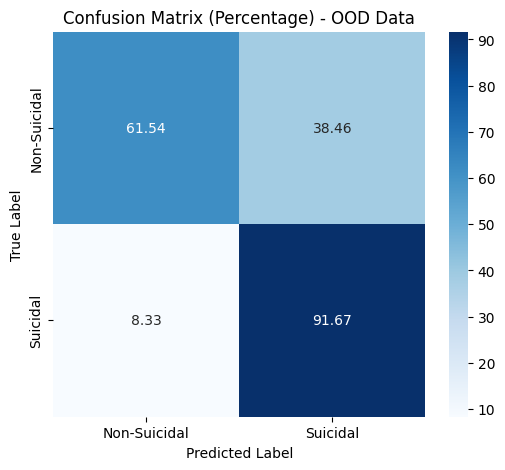

In [99]:
# Convert Confusion Matrix to Percentage
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix with Percentages
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Non-Suicidal", "Suicidal"], yticklabels=["Non-Suicidal", "Suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage) - OOD Data")
plt.show()